# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-09-30 20:28:39.676713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 20:28:40.302562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 70
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)


# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, _ = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, _ = self.rnn2(output)
    output = self.dropout2(output)
    
    output, _ = self.rnn3(output)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1270/1270 [05:23<00:00,  3.92batch/s, loss=6.29, perplexity=914]    


Valid: Loss = 5.308 Perplexity= 211.2, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1270/1270 [05:28<00:00,  3.86batch/s, loss=5.64, perplexity=291]


Valid: Loss = 5.055 Perplexity= 163.4, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1270/1270 [05:28<00:00,  3.86batch/s, loss=5.42, perplexity=231]


Valid: Loss = 4.909 Perplexity= 140.9, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1270/1270 [05:28<00:00,  3.86batch/s, loss=5.26, perplexity=197]


Valid: Loss = 4.816 Perplexity= 128.4, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1270/1270 [05:29<00:00,  3.86batch/s, loss=5.13, perplexity=174]


Valid: Loss = 4.751 Perplexity= 120.4, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1270/1270 [05:03<00:00,  4.18batch/s, loss=5.03, perplexity=157]


Valid: Loss = 4.704 Perplexity= 114.9, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1270/1270 [05:19<00:00,  3.98batch/s, loss=4.94, perplexity=144]


Valid: Loss = 4.667 Perplexity= 110.8, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1270/1270 [05:19<00:00,  3.97batch/s, loss=4.86, perplexity=134]


Valid: Loss = 4.645 Perplexity= 108.4, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1270/1270 [05:23<00:00,  3.93batch/s, loss=4.79, perplexity=125]


Valid: Loss = 4.616 Perplexity= 105.3, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1270/1270 [05:03<00:00,  4.18batch/s, loss=4.73, perplexity=118]


Valid: Loss = 4.606 Perplexity= 104.3, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1270/1270 [05:08<00:00,  4.12batch/s, loss=4.68, perplexity=112]


Valid: Loss = 4.593 Perplexity= 103.0, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1270/1270 [05:07<00:00,  4.12batch/s, loss=4.63, perplexity=106]


Valid: Loss = 4.582 Perplexity= 102.0, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1270/1270 [04:59<00:00,  4.23batch/s, loss=4.58, perplexity=102]


Valid: Loss = 4.574 Perplexity= 101.2, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1270/1270 [05:07<00:00,  4.13batch/s, loss=4.54, perplexity=97.8]


Valid: Loss = 4.568 Perplexity= 100.8, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1270/1270 [05:13<00:00,  4.05batch/s, loss=4.5, perplexity=94]   


Valid: Loss = 4.57 Perplexity= 100.8, LR = 0.5



Epoch 15: 100%|██████████| 1270/1270 [05:12<00:00,  4.07batch/s, loss=4.42, perplexity=87]  


Valid: Loss = 4.501 Perplexity= 94.1, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.38, perplexity=83]  


Valid: Loss = 4.498 Perplexity= 93.91, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1270/1270 [05:17<00:00,  4.01batch/s, loss=4.35, perplexity=80.8]


Valid: Loss = 4.493 Perplexity= 93.46, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 1270/1270 [05:23<00:00,  3.92batch/s, loss=4.33, perplexity=78.8]


Valid: Loss = 4.493 Perplexity= 93.52, LR = 0.25



Epoch 19: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.29, perplexity=76.1]


Valid: Loss = 4.448 Perplexity= 89.4, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 1270/1270 [05:37<00:00,  3.77batch/s, loss=4.26, perplexity=74]  


Valid: Loss = 4.445 Perplexity= 89.2, LR = 0.125
Model Saved!



Epoch 21: 100%|██████████| 1270/1270 [05:37<00:00,  3.76batch/s, loss=4.24, perplexity=72.6]


Valid: Loss = 4.439 Perplexity= 88.61, LR = 0.125
Model Saved!



Epoch 22: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.23, perplexity=71.4]


Valid: Loss = 4.435 Perplexity= 88.25, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 1270/1270 [05:21<00:00,  3.95batch/s, loss=4.21, perplexity=70.4]


Valid: Loss = 4.437 Perplexity= 88.5, LR = 0.125



Epoch 24: 100%|██████████| 1270/1270 [05:12<00:00,  4.06batch/s, loss=4.2, perplexity=69.4] 


Valid: Loss = 4.393 Perplexity= 84.56, LR = 0.0625
Model Saved!



Epoch 25: 100%|██████████| 1270/1270 [05:27<00:00,  3.88batch/s, loss=4.18, perplexity=68.4]


Valid: Loss = 4.388 Perplexity= 84.09, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.17, perplexity=67.7]


Valid: Loss = 4.386 Perplexity= 83.95, LR = 0.0625
Model Saved!



Epoch 27: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.16, perplexity=67.1]


Valid: Loss = 4.385 Perplexity= 83.9, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.15, perplexity=66.5]


Valid: Loss = 4.385 Perplexity= 83.85, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.15, perplexity=65.9]


Valid: Loss = 4.378 Perplexity= 83.31, LR = 0.0625
Model Saved!



Epoch 30: 100%|██████████| 1270/1270 [05:10<00:00,  4.09batch/s, loss=4.14, perplexity=65.4]


Valid: Loss = 4.381 Perplexity= 83.54, LR = 0.0625



Epoch 31: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.14, perplexity=65.3]


Valid: Loss = 4.36 Perplexity= 81.79, LR = 0.03125
Model Saved!



Epoch 32: 100%|██████████| 1270/1270 [05:01<00:00,  4.21batch/s, loss=4.13, perplexity=64.8]


Valid: Loss = 4.357 Perplexity= 81.51, LR = 0.03125
Model Saved!



Epoch 33: 100%|██████████| 1270/1270 [05:37<00:00,  3.77batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.356 Perplexity= 81.45, LR = 0.03125
Model Saved!



Epoch 34: 100%|██████████| 1270/1270 [05:36<00:00,  3.78batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.356 Perplexity= 81.47, LR = 0.03125



Epoch 35: 100%|██████████| 1270/1270 [05:47<00:00,  3.65batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.34 Perplexity= 80.21, LR = 0.015625
Model Saved!



Epoch 36: 100%|██████████| 1270/1270 [05:35<00:00,  3.78batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.339 Perplexity= 80.1, LR = 0.015625
Model Saved!



Epoch 37: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.12, perplexity=64]  


Valid: Loss = 4.337 Perplexity= 79.92, LR = 0.015625
Model Saved!



Epoch 38: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.11, perplexity=63.9]


Valid: Loss = 4.338 Perplexity= 79.98, LR = 0.015625



Epoch 39: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.326 Perplexity= 79.03, LR = 0.0078125
Model Saved!



Epoch 40: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.326 Perplexity= 79.05, LR = 0.0078125



Epoch 41: 100%|██████████| 1270/1270 [05:32<00:00,  3.82batch/s, loss=4.13, perplexity=64.7]


Valid: Loss = 4.323 Perplexity= 78.81, LR = 0.00390625
Model Saved!



Epoch 42: 100%|██████████| 1270/1270 [05:12<00:00,  4.07batch/s, loss=4.12, perplexity=64.7]


Valid: Loss = 4.322 Perplexity= 78.76, LR = 0.00390625
Model Saved!



Epoch 43: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.321 Perplexity= 78.67, LR = 0.00390625
Model Saved!



Epoch 44: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.321 Perplexity= 78.69, LR = 0.00390625



Epoch 45: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.13, perplexity=64.8]


Valid: Loss = 4.318 Perplexity= 78.42, LR = 0.001953125
Model Saved!



Epoch 46: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.13, perplexity=64.8]


Valid: Loss = 4.317 Perplexity= 78.31, LR = 0.001953125
Model Saved!



Epoch 47: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.13, perplexity=64.7]


Valid: Loss = 4.316 Perplexity= 78.26, LR = 0.001953125
Model Saved!



Epoch 48: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.12, perplexity=64.7]


Valid: Loss = 4.316 Perplexity= 78.26, LR = 0.001953125



Epoch 49: 100%|██████████| 1270/1270 [05:31<00:00,  3.83batch/s, loss=4.13, perplexity=64.8]


Valid: Loss = 4.312 Perplexity= 77.96, LR = 0.0009765625
Model Saved!



Epoch 50: 100%|██████████| 1270/1270 [05:30<00:00,  3.84batch/s, loss=4.12, perplexity=64.7]


Valid: Loss = 4.312 Perplexity= 77.92, LR = 0.0009765625
Model Saved!



Epoch 51: 100%|██████████| 1270/1270 [05:30<00:00,  3.84batch/s, loss=4.12, perplexity=64.6]


Valid: Loss = 4.311 Perplexity= 77.89, LR = 0.0009765625
Model Saved!



Epoch 52: 100%|██████████| 1270/1270 [05:30<00:00,  3.85batch/s, loss=4.12, perplexity=64.6]


Valid: Loss = 4.311 Perplexity= 77.88, LR = 0.0009765625
Model Saved!



Epoch 53: 100%|██████████| 1270/1270 [05:18<00:00,  3.99batch/s, loss=4.12, perplexity=64.6]


Valid: Loss = 4.311 Perplexity= 77.87, LR = 0.0009765625
Model Saved!



Epoch 54: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.311 Perplexity= 77.87, LR = 0.0009765625
Model Saved!



Epoch 55: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.311 Perplexity= 77.86, LR = 0.0009765625
Model Saved!



Epoch 56: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.311 Perplexity= 77.84, LR = 0.0009765625
Model Saved!



Epoch 57: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.5]


Valid: Loss = 4.311 Perplexity= 77.83, LR = 0.0009765625
Model Saved!



Epoch 58: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.4]


Valid: Loss = 4.31 Perplexity= 77.82, LR = 0.0009765625
Model Saved!



Epoch 59: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.4]


Valid: Loss = 4.31 Perplexity= 77.83, LR = 0.0009765625



Epoch 60: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.4]


Valid: Loss = 4.309 Perplexity= 77.75, LR = 0.00048828125
Model Saved!



Epoch 61: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.72, LR = 0.00048828125
Model Saved!



Epoch 62: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.4]


Valid: Loss = 4.309 Perplexity= 77.71, LR = 0.00048828125
Model Saved!



Epoch 63: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.4]


Valid: Loss = 4.309 Perplexity= 77.7, LR = 0.00048828125
Model Saved!



Epoch 64: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.7, LR = 0.00048828125
Model Saved!



Epoch 65: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.7, LR = 0.00048828125
Model Saved!



Epoch 66: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.69, LR = 0.00048828125
Model Saved!



Epoch 67: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.68, LR = 0.00048828125
Model Saved!



Epoch 68: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.3]


Valid: Loss = 4.309 Perplexity= 77.69, LR = 0.00048828125



Epoch 69: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.66, LR = 0.000244140625
Model Saved!



Epoch 70: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.65, LR = 0.000244140625
Model Saved!



Epoch 71: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.65, LR = 0.000244140625
Model Saved!



Epoch 72: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.64, LR = 0.000244140625
Model Saved!



Epoch 73: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.63, LR = 0.000244140625
Model Saved!



Epoch 74: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.63, LR = 0.000244140625
Model Saved!



Epoch 75: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.63, LR = 0.000244140625



Epoch 76: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.62, LR = 0.0001220703125
Model Saved!



Epoch 77: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.62, LR = 0.0001220703125
Model Saved!



Epoch 78: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.62, LR = 0.0001220703125
Model Saved!



Epoch 79: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.62, LR = 0.0001220703125
Model Saved!



Epoch 80: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 81: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 82: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 83: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 84: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 85: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.61, LR = 0.0001220703125
Model Saved!



Epoch 86: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 87: 100%|██████████| 1270/1270 [05:09<00:00,  4.10batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 88: 100%|██████████| 1270/1270 [05:13<00:00,  4.05batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 89: 100%|██████████| 1270/1270 [04:58<00:00,  4.25batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 90: 100%|██████████| 1270/1270 [04:58<00:00,  4.25batch/s, loss=4.12, perplexity=64.2]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 91: 100%|██████████| 1270/1270 [04:58<00:00,  4.25batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 92: 100%|██████████| 1270/1270 [04:58<00:00,  4.25batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 93: 100%|██████████| 1270/1270 [04:58<00:00,  4.25batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.6, LR = 0.0001220703125
Model Saved!



Epoch 94: 100%|██████████| 1270/1270 [04:55<00:00,  4.30batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.59, LR = 0.0001220703125
Model Saved!



Epoch 95: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.59, LR = 0.0001220703125
Model Saved!



Epoch 96: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.308 Perplexity= 77.59, LR = 0.0001220703125



Epoch 97: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 6.103515625e-05
Model Saved!



Epoch 98: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 6.103515625e-05
Model Saved!



Epoch 99: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 6.103515625e-05



Epoch 100: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 101: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 102: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 103: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 104: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 105: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 106: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 107: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 108: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 109: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 110: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 111: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 112: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05
Model Saved!



Epoch 113: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.0517578125e-05



Epoch 114: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 1.52587890625e-05
Model Saved!



Epoch 115: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 1.52587890625e-05



Epoch 116: 100%|██████████| 1270/1270 [04:54<00:00,  4.32batch/s, loss=4.11, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 7.62939453125e-06
Model Saved!



Epoch 117: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 7.62939453125e-06



Epoch 118: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.814697265625e-06
Model Saved!



Epoch 119: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.814697265625e-06
Model Saved!



Epoch 120: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.12, perplexity=64.1]


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.814697265625e-06
Model Saved!



Epoch 121: 100%|██████████| 1270/1270 [04:54<00:00,  4.31batch/s, loss=4.11, perplexity=64]  


Valid: Loss = 4.307 Perplexity= 77.59, LR = 3.814697265625e-06



Epoch 122:  66%|██████▌   | 840/1270 [03:17<01:41,  4.25batch/s, loss=4.11, perplexity=63.5]


KeyboardInterrupt: 

## Learning Curve

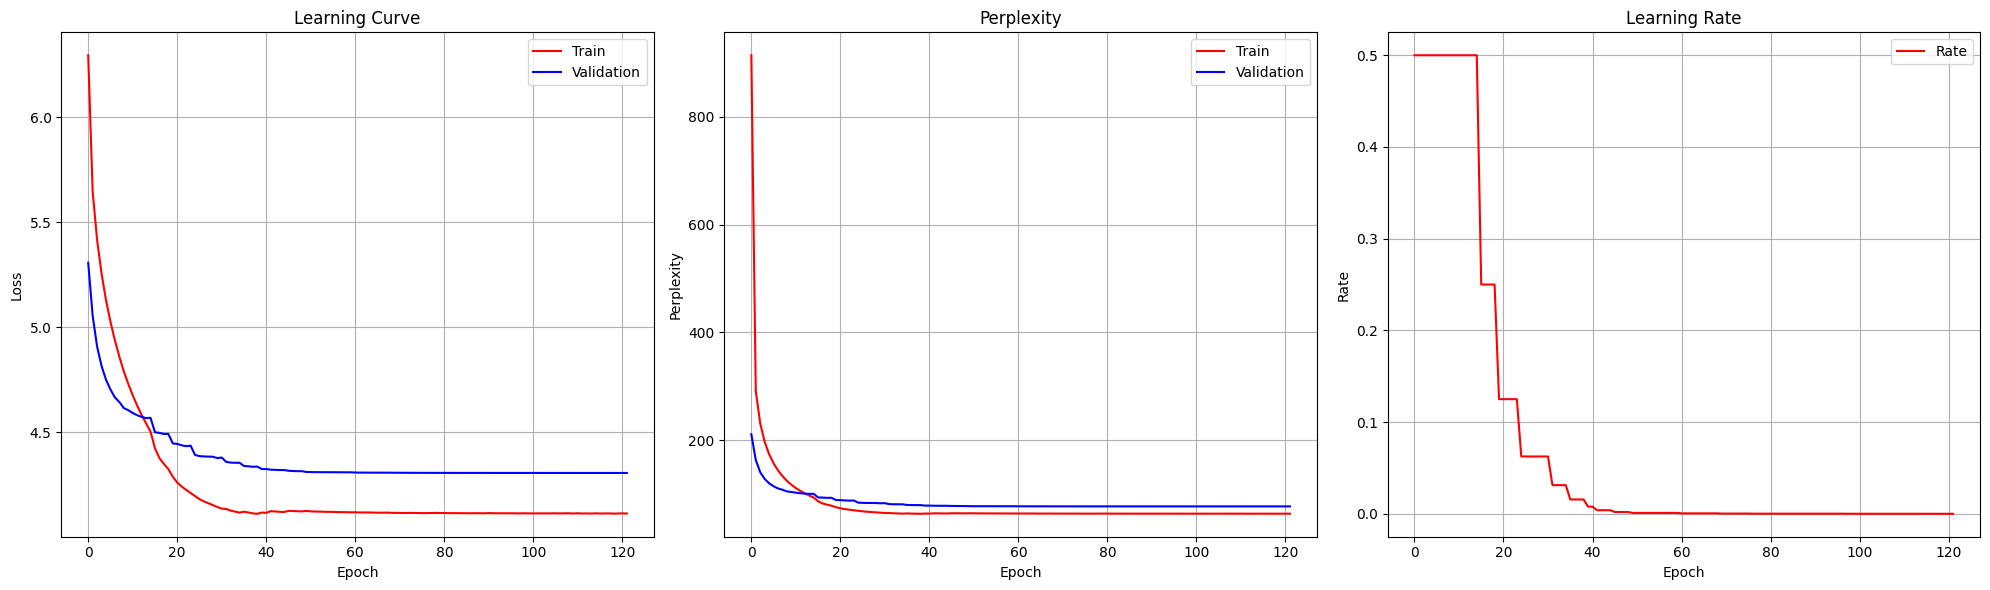

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.307 , Perplexity = 77.59
Test: Loss = 4.193 , Perplexity = 71.22


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [26]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie has been used to make the music of the song .
